<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import os
import socket

repo_name = "DD2424-project"
dep_filename = "download_dataset.py"
cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

if os.path.exists(dep_filename):
    print(f"{dep_filename} is in your current directory. Assuming you are in the root of the repository.")
elif not os.path.exists(repo_name):
    print(f"Cloning repo and fetching {dep_filename}...")
    !git clone https://github.com/Sebelino/DD2424-project
    !cp DD2424-project/download_dataset.py .
else:
    !git -C DD2424-project pull --rebase
    !cp DD2424-project/download_dataset.py .

Host: deeplearning-vm
You are here: /home/silpasoninallacheruvu/DD2424-project
download_dataset.py is in your current directory. Assuming you are in the root of the repository.


# Load data

In [2]:
import random
import numpy as np
import torch
import torchvision
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader, random_split

# Use ResNet's default preprocessing pipeline
weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()


def load_dataset(split_name: str):
    return torchvision.datasets.OxfordIIITPet(
        root="./data",
        split=split_name,
        target_types="binary-category",
        download=True,
        transform=transform,
    )


train_dataset = load_dataset("trainval")
test_dataset = load_dataset("test")

shrink_dataset = False
if shrink_dataset:
    subset_size = 1000
    small_train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))
    small_train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True)
    train_dataset = small_train_dataset


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Slower, but reproducible
    os.environ['PYTHONHASHSEED'] = str(seed)


global_seed = 42
set_seed(global_seed)

# DataLoaders
batch_size = 32
num_workers = 2
# 80% train, 20% val split
num_train = int(0.8 * len(train_dataset))
num_val = len(train_dataset) - num_train
train_subset, val_subset = random_split(train_dataset, [num_train, num_val],
                                        generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    worker_init_fn=lambda worker_id: np.random.seed(global_seed + worker_id),
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

print(
    f"Batch size: {train_loader.batch_size}, Train/Val/Test size: {len(train_loader.dataset)}:{len(val_loader.dataset)}:{len(test_loader.dataset)}, Iterations per epoch: {len(train_loader)}")


Batch size: 32, Train/Val/Test size: 2944:736:3669, Iterations per epoch: 92


# Set up model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet50
model = models.resnet50(weights=weights)

# Freeze earlier layers (improves performance)
freeze_layers = True
if freeze_layers:
    for param in model.parameters():
        param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Binary classification (cat vs dog)

# Ensure final layer is trainable
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

print(f"GPU acceleration enabled: {'Yes 🚀' if device.type == 'cuda' else 'No 🐌'}")

GPU acceleration enabled: Yes 🚀


# Train model

In [7]:

from typing import Literal
from torch import GradScaler, autocast


def make_optimizer(optimization: Literal["nag", "adam"]):
    if optimization == "adam":
        return optim.Adam(
            model.fc.parameters(),
            lr=0.001
        )
    elif optimization == "nag":
        return optim.SGD(
            model.fc.parameters(),
            lr=0.01,
            momentum=0.9,
            nesterov=True,
            weight_decay=1e-4,
        )
    else:
        raise NotImplementedError


optimizer = make_optimizer("nag")

criterion = nn.CrossEntropyLoss()

num_epochs = 5
model.train()


def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return 100 * correct / total


def backward_pass(model, inputs, labels, criterion, scaler=None):
    if scaler is not None:
        with autocast(device_type='cuda'):  # Mixed precision enabled
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    else:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    return outputs, loss


enable_mixed_precision = False
scaler = GradScaler() if enable_mixed_precision else None

validate = True

train_accuracies = []
val_accuracies = []
epoch_losses = []

for epoch in tqdm(range(num_epochs), desc="Epoch"):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, loss = backward_pass(model, inputs, labels, criterion, scaler)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = 100 * correct / total

    if validate:
        val_acc = evaluate(model, val_loader, device)
        val_acc_str = f", Val Acc: {val_acc:.2f}%"
    else:
        val_acc = None
        val_acc_str = ""

    # Store for plotting
    epoch_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)
    if validate:
        val_accuracies.append(val_acc)

    tqdm.write(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}%{val_acc_str}")

import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/92 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Benchmarking
This is low long training takes for different combinations of optimizations (in Colab):
```
1:13 mixed_precision=no  num_workers=1 pin_memory=False data=1000 batch_size=32
1:11 mixed_precision=no  num_workers=1 pin_memory=False data=1000 batch_size=32
1:07 mixed_precision=yes num_workers=1 pin_memory=False data=1000 batch_size=32
1:07 mixed_precision=yes num_workers=1 pin_memory=False data=1000 batch_size=32
1:01 mixed_precision=no  num_workers=2 pin_memory=True  data=1000 batch_size=32
3:42 mixed_precision=no  num_workers=2 pin_memory=True  data=all  batch_size=32
3:34 mixed_precision=yes num_workers=2 pin_memory=True  data=all  batch_size=32
3:45 mixed_precision=yes num_workers=2 pin_memory=True  data=all  batch_size=64
3:46 mixed_precision=yes num_workers=2 pin_memory=False data=all  batch_size=32
4:16 mixed_precision=yes num_workers=1 pin_memory=False data=all  batch_size=32

After standard traingval/test split, with L4 GPU:
1:03 mixed_precision=yes num_workers=2 pin_memory=True data=all batch_size=32 freeze_layers=False
1:02 mixed_precision=yes num_workers=2 pin_memory=True data=all batch_size=32 freeze_layers=False
1:01 mixed_precision=yes num_workers=2 pin_memory=True data=all batch_size=32 freeze_layers=True
1:01 mixed_precision=yes num_workers=2 pin_memory=True data=all batch_size=32 freeze_layers=True
1:01 mixed_precision=no  num_workers=2 pin_memory=True data=all batch_size=32 freeze_layers=True
1:05 mixed_precision=no  num_workers=2 pin_memory=True data=all batch_size=32 freeze_layers=True cold_start=yes
1:01 mixed_precision=no  num_workers=2 pin_memory=True data=all batch_size=32 freeze_layers=True seed=yes
```

# Test model

In [5]:
import shutil

# Directory for saving misclassified images
misclassified_dir = "./misclassified"

if os.path.exists(misclassified_dir):
    shutil.rmtree(misclassified_dir)
os.makedirs(misclassified_dir, exist_ok=True)


# Evaluate and collect misclassified samples
def evaluate_and_collect_misclassified(model, loader, device, dataset):
    model.eval()
    correct = 0
    total = 0
    misclassified = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(tqdm(loader, desc="Evaluating")):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(inputs.size(0)):
                if predicted[i] != labels[i]:
                    img_idx = idx * loader.batch_size + i
                    img_path = dataset._images[img_idx]
                    true_label = dataset._bin_labels[img_idx]
                    misclassified.append((img_path, true_label, predicted[i].item()))

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    model.train()
    return 100 * correct / total, misclassified


final_test_acc, misclassified_samples = evaluate_and_collect_misclassified(model, test_loader, device, test_dataset)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
print(f"Number of misclassified samples: {len(misclassified_samples)}")


def to_text(label: int):
    return {
        0: "cat",
        1: "dog",
    }[label]


from PIL import Image

# Plot the first 5 misclassified images
num_to_plot = min(5, len(misclassified_samples))
plt.figure(figsize=(15, 5))

for i in range(num_to_plot):
    img_path, true_label, predicted_label = misclassified_samples[i]
    img = Image.open(img_path)
    plt.subplot(1, num_to_plot, i + 1)
    plt.imshow(img)
    plt.title(f"True: {to_text(true_label)}, Pred: {to_text(predicted_label)}")
    plt.axis('off')

plt.show()

for i, (img_path, true_label, predicted_label) in enumerate(misclassified_samples):
    filename = os.path.basename(img_path)
    new_filename = f"{i:04d}_true{true_label}_pred{predicted_label}_{filename}"
    shutil.copy(img_path, os.path.join(misclassified_dir, new_filename))

print(f"Copied {len(misclassified_samples)} misclassified images to {misclassified_dir}")


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 99.26%
Number of misclassified samples: 27


NameError: name 'plt' is not defined

In [7]:
def unfreeze_last_layers(model, l):
    # Freeze everything first
    for param in model.parameters():
        param.requires_grad = False

    # Always unfreeze the final fully connected layer
    for param in model.fc.parameters():
        param.requires_grad = True

    # Get all layers in the ResNet 
    layer_blocks = [
        model.layer4,
        model.layer3,
        model.layer2,
        model.layer1,
        model.conv1,
        model.bn1,
    ]

    # Unfreeze the last l blocks 
    for i in range(l):
        for param in layer_blocks[i].parameters():
            param.requires_grad = True


In [8]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return 100 * correct / total


In [9]:
def load_dataset(split_name: str):
    return torchvision.datasets.OxfordIIITPet(
        root="./data",
        split=split_name,
        target_types="category",
        download=True,
        transform=transform,
    )


train_dataset = load_dataset("trainval")
test_dataset = load_dataset("test")

# DataLoaders
batch_size = 32
num_workers = 2
# 80% train, 20% val split
num_train = int(0.8 * len(train_dataset))
num_val = len(train_dataset) - num_train
train_subset, val_subset = random_split(train_dataset, [num_train, num_val],
                                        generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    worker_init_fn=lambda worker_id: np.random.seed(global_seed + worker_id),
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

print(
    f"Batch size: {train_loader.batch_size}, Train/Val/Test size: {len(train_loader.dataset)}:{len(val_loader.dataset)}:{len(test_loader.dataset)}, Iterations per epoch: {len(train_loader)}")


Batch size: 32, Train/Val/Test size: 2944:736:3669, Iterations per epoch: 92


In [20]:
results = {}

def backward_pass(model, inputs, labels, criterion, optimizer, scaler=None):
    if scaler is not None:
        with autocast(device_type='cuda'):  # Mixed precision enabled
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    else:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    return outputs, loss


for l in range(1, 6):  
    print(f"\n Fine-tuning with last {l} layers unfrozen...\n")
    
    # Reload model from scratch
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 37)
    model = model.to(device)

    # Unfreeze last l layers
    unfreeze_last_layers(model, l)

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4
    )

    # Reset history
    train_accuracies, val_accuracies, epoch_losses = [], [], []
 
    for epoch in range(10):#5 epochs
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, loss = backward_pass(model, inputs, labels, criterion, optimizer, scaler)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate(model, test_loader, device)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        epoch_losses.append(running_loss / len(train_loader))

#         print(
#             f"Epoch {epoch + 1}, Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%"
#         )

#     results[l] = {
#         "train_acc": train_accuracies,
#         "val_acc": val_accuracies,
#         "loss": epoch_losses,
#     }
    avg_train_acc = sum(train_accuracies) / len(train_accuracies)
    avg_val_acc = sum(val_accuracies) / len(val_accuracies)
    print(f"\n [l = {l}] Average Train Accuracy: {avg_train_acc:.2f}%")
    print(f" [l = {l}] Average Validation Accuracy: {avg_val_acc:.2f}%\n")
    


 Fine-tuning with last 1 layers unfrozen...



Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]


 [l = 1] Average Train Accuracy: 93.33%
 [l = 1] Average Validation Accuracy: 90.81%


 Fine-tuning with last 2 layers unfrozen...



Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]


 [l = 2] Average Train Accuracy: 94.22%
 [l = 2] Average Validation Accuracy: 91.04%


 Fine-tuning with last 3 layers unfrozen...



Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]


 [l = 3] Average Train Accuracy: 94.18%
 [l = 3] Average Validation Accuracy: 91.50%


 Fine-tuning with last 4 layers unfrozen...



Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]


 [l = 4] Average Train Accuracy: 94.20%
 [l = 4] Average Validation Accuracy: 91.27%


 Fine-tuning with last 5 layers unfrozen...



Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]


 [l = 5] Average Train Accuracy: 93.98%
 [l = 5] Average Validation Accuracy: 91.31%



Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Final Test Accuracy: 92.37%
Number of misclassified samples: 280


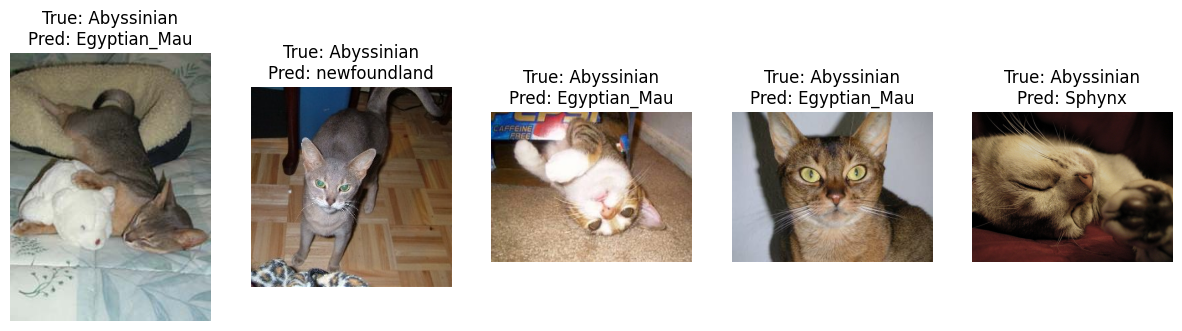

Copied 280 misclassified images to ./misclassified2


In [21]:
import shutil

# Directory for saving misclassified images
misclassified_dir = "./misclassified2"

if os.path.exists(misclassified_dir):
    shutil.rmtree(misclassified_dir)
os.makedirs(misclassified_dir, exist_ok=True)


# Evaluate and collect misclassified samples
def evaluate_and_collect_misclassified(model, loader, device, dataset):
    model.eval()
    correct = 0
    total = 0
    misclassified = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(tqdm(loader, desc="Evaluating")):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(inputs.size(0)):
                if predicted[i] != labels[i]:
                    img_idx = idx * loader.batch_size + i
                    img_path = dataset._images[img_idx]
                    true_label = dataset._bin_labels[img_idx]
                    misclassified.append((img_path, true_label, predicted[i].item()))

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    model.train()
    return 100 * correct / total, misclassified


final_test_acc, misclassified_samples = evaluate_and_collect_misclassified(model, test_loader, device, test_dataset)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
print(f"Number of misclassified samples: {len(misclassified_samples)}")


def to_text(label: int):
    breed_names = [
        "Abyssinian", "Bengal", "Birman", "Bombay", "British_Shorthair", "Egyptian_Mau",
        "Maine_Coon", "Persian", "Ragdoll", "Russian_Blue", "Siamese", "Sphynx",
        "american_bulldog", "american_pit_bull_terrier", "basset_hound", "beagle",
        "boxer", "chihuahua", "english_cocker_spaniel", "english_setter", "german_shorthaired",
        "great_pyrenees", "havanese", "japanese_chin", "keeshond", "leonberger",
        "miniature_pinscher", "newfoundland", "pomeranian", "pug", "saint_bernard",
        "samoyed", "scottish_terrier", "shiba_inu", "staffordshire_bull_terrier", "wheaten_terrier",
        "yorkshire_terrier"
    ]
    return breed_names[label]



from PIL import Image
import matplotlib.pyplot as plt

# Plot the first 5 misclassified images
num_to_plot = min(5, len(misclassified_samples))
plt.figure(figsize=(15, 5))

for i in range(num_to_plot):
    img_path, true_label, predicted_label = misclassified_samples[i]
    img = Image.open(img_path)
    plt.subplot(1, num_to_plot, i + 1)
    plt.imshow(img)
    plt.title(f"True: {to_text(true_label)}\nPred: {to_text(predicted_label)}")
    plt.axis('off')

plt.show()

for i, (img_path, true_label, predicted_label) in enumerate(misclassified_samples):
    filename = os.path.basename(img_path)
    new_filename = f"{i:04d}_true{true_label}_pred{predicted_label}_{filename}"
    shutil.copy(img_path, os.path.join(misclassified_dir, new_filename))

print(f"Copied {len(misclassified_samples)} misclassified images to {misclassified_dir}")


In [10]:
# learning rates schedule for different layers

from torch import GradScaler, autocast

results = {}
criterion = nn.CrossEntropyLoss()
enable_mixed_precision = False
scaler = GradScaler() if enable_mixed_precision else None


def backward_pass(model, inputs, labels, criterion, optimizer, scaler=None):
    if scaler is not None:
        with autocast(device_type='cuda'):  # Mixed precision enabled
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    else:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    return outputs, loss


for l in range(1, 6):  
    print(f"\n Fine-tuning with last {l} layers unfrozen...\n")
    
    # Reload model from scratch
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 37)
    model = model.to(device)

    # Unfreeze last l layers
    unfreeze_last_layers(model, l)
    
    # Separate parameters cleanly
    fc_params = list(model.fc.parameters())

    # Backbone parameters = all params except model.fc
    backbone_params = [p for n, p in model.named_parameters() if p.requires_grad and not n.startswith('fc')]

    # Create parameter groups
    param_groups = [
        {"params": fc_params, "lr": 1e-3},      # Final layer with higher LR
        {"params": backbone_params, "lr": 1e-4} # Backbone with lower LR
    ]

    # Create optimizer
    optimizer = optim.Adam(param_groups, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Reset history
    train_accuracies, val_accuracies, epoch_losses = [], [], []
 
    for epoch in range(5):#5 epochs
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, loss = backward_pass(model, inputs, labels, criterion, optimizer, scaler)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate(model, test_loader, device)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        epoch_losses.append(running_loss / len(train_loader))

        print(
            f"Epoch {epoch + 1}, Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%"
        )
        scheduler.step()

    results[l] = {
        "train_acc": train_accuracies,
        "val_acc": val_accuracies,
        "loss": epoch_losses,
    }
    avg_train_acc = sum(train_accuracies) / len(train_accuracies)
    avg_val_acc = sum(val_accuracies) / len(val_accuracies)
    print(f"\n [l = {l}] Average Train Accuracy: {avg_train_acc:.2f}%")
    print(f" [l = {l}] Average Validation Accuracy: {avg_val_acc:.2f}%\n")
    
    


 Fine-tuning with last 1 layers unfrozen...



Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1, Loss: 109.6845, Train Acc: 74.32%, Val Acc: 90.52%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2, Loss: 13.6362, Train Acc: 95.52%, Val Acc: 90.05%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3, Loss: 5.1424, Train Acc: 98.57%, Val Acc: 91.22%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4, Loss: 1.7776, Train Acc: 99.76%, Val Acc: 91.14%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5, Loss: 1.6783, Train Acc: 99.69%, Val Acc: 91.85%

 [l = 1] Average Train Accuracy: 93.57%
 [l = 1] Average Validation Accuracy: 90.96%


 Fine-tuning with last 2 layers unfrozen...



Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1, Loss: 106.8363, Train Acc: 72.52%, Val Acc: 88.99%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2, Loss: 11.6394, Train Acc: 96.40%, Val Acc: 89.81%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3, Loss: 5.3723, Train Acc: 98.61%, Val Acc: 90.84%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4, Loss: 2.0992, Train Acc: 99.39%, Val Acc: 91.58%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5, Loss: 2.5663, Train Acc: 99.08%, Val Acc: 90.00%

 [l = 2] Average Train Accuracy: 93.20%
 [l = 2] Average Validation Accuracy: 90.24%


 Fine-tuning with last 3 layers unfrozen...



Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1, Loss: 104.5479, Train Acc: 73.61%, Val Acc: 90.95%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2, Loss: 11.0027, Train Acc: 96.40%, Val Acc: 91.11%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3, Loss: 3.7363, Train Acc: 99.08%, Val Acc: 91.61%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4, Loss: 2.7256, Train Acc: 99.18%, Val Acc: 89.94%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5, Loss: 1.2709, Train Acc: 99.76%, Val Acc: 91.55%

 [l = 3] Average Train Accuracy: 93.61%
 [l = 3] Average Validation Accuracy: 91.03%


 Fine-tuning with last 4 layers unfrozen...



Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1, Loss: 109.2517, Train Acc: 71.77%, Val Acc: 89.34%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2, Loss: 12.0592, Train Acc: 96.40%, Val Acc: 90.57%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3, Loss: 4.5147, Train Acc: 98.64%, Val Acc: 90.57%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4, Loss: 2.1668, Train Acc: 99.46%, Val Acc: 91.69%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5, Loss: 1.3666, Train Acc: 99.69%, Val Acc: 91.25%

 [l = 4] Average Train Accuracy: 93.19%
 [l = 4] Average Validation Accuracy: 90.68%


 Fine-tuning with last 5 layers unfrozen...



Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1, Loss: 105.0264, Train Acc: 73.51%, Val Acc: 87.19%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2, Loss: 11.7326, Train Acc: 96.06%, Val Acc: 90.98%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3, Loss: 4.0869, Train Acc: 98.81%, Val Acc: 90.08%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4, Loss: 2.8279, Train Acc: 99.22%, Val Acc: 90.68%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5, Loss: 1.5154, Train Acc: 99.63%, Val Acc: 89.45%

 [l = 5] Average Train Accuracy: 93.44%
 [l = 5] Average Validation Accuracy: 89.68%



In [18]:
# Data augmentation - normalised flip and rotation
from torchvision import transforms

# Define training transformations
train_transforms = transforms.Compose([
#     transforms.Resize((256, 256)),            # Resize to a slightly larger size
#     transforms.RandomResizedCrop(224),         # Random crop to 224x224
    transforms.RandomHorizontalFlip(),         # Random flip with probability 0.5
    transforms.RandomRotation(15),             # Random rotation within +/-15 degrees
    transforms.ToTensor()                      # Convert to tensor
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],             # Imagenet mean
#         std=[0.229, 0.224, 0.225]               # Imagenet std
#     )
])

# Validation should not have randomness
val_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
    transforms.ToTensor()
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]
#     )
])

def load_dataset(split_name: str, transforms):
    return torchvision.datasets.OxfordIIITPet(
        root="./data",
        split=split_name,
        target_types="category",
        download=True,
        transform=transform,
    )


train_dataset = load_dataset("trainval", train_transforms)
test_dataset = load_dataset("test", val_transforms)

# DataLoaders
batch_size = 64
num_workers = 2
# 80% train, 20% val split
num_train = int(0.8 * len(train_dataset))
num_val = len(train_dataset) - num_train
train_subset, val_subset = random_split(train_dataset, [num_train, num_val],
                                        generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    worker_init_fn=lambda worker_id: np.random.seed(global_seed + worker_id),
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

print(
    f"Batch size: {train_loader.batch_size}, Train/Val/Test size: {len(train_loader.dataset)}:{len(val_loader.dataset)}:{len(test_loader.dataset)}, Iterations per epoch: {len(train_loader)}")


Batch size: 64, Train/Val/Test size: 2944:736:3669, Iterations per epoch: 46


In [12]:
# cyclic learning rates schedule for different layers

from torch import GradScaler, autocast

results = {}
criterion = nn.CrossEntropyLoss()
enable_mixed_precision = False
scaler = GradScaler() if enable_mixed_precision else None


def backward_pass(model, inputs, labels, criterion, optimizer, scaler=None):
    if scaler is not None:
        with autocast(device_type='cuda'):  # Mixed precision enabled
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    else:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    return outputs, loss


for l in range(1, 6):  
    print(f"\n Fine-tuning with last {l} layers unfrozen...\n")
    
    # Reload model from scratch
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 37)
    model = model.to(device)

    # Unfreeze last l layers
    unfreeze_last_layers(model, l)
    
    # Separate parameters cleanly
    fc_params = list(model.fc.parameters())

    # Backbone parameters = all params except model.fc
    backbone_params = [p for n, p in model.named_parameters() if p.requires_grad and not n.startswith('fc')]

    # Create parameter groups
    param_groups = [
        {"params": fc_params},     
        {"params": backbone_params} 
    ]

    # Create optimizer
    optimizer = optim.Adam(param_groups, weight_decay=1e-4) # LR regularisation
    scheduler = torch.optim.lr_scheduler.CyclicLR(  # cyclic learning rate scheduler
        optimizer,
        base_lr=[1e-5, 1e-6],
        max_lr=[1e-3, 1e-4],
        step_size_up=2000,
        mode="triangular",
        cycle_momentum=False
    )

    # Reset history
    train_accuracies, val_accuracies, epoch_losses = [], [], []
 
    for epoch in range(5):#5 epochs
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, loss = backward_pass(model, inputs, labels, criterion, optimizer, scaler)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate(model, test_loader, device)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        epoch_losses.append(running_loss / len(train_loader))

        print(
            f"Epoch {epoch + 1}, Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%"
        )
        scheduler.step()

    results[l] = {
        "train_acc": train_accuracies,
        "val_acc": val_accuracies,
        "loss": epoch_losses,
    }
    avg_train_acc = sum(train_accuracies) / len(train_accuracies)
    avg_val_acc = sum(val_accuracies) / len(val_accuracies)
    print(f"\n [l = {l}] Average Train Accuracy: {avg_train_acc:.2f}%")
    print(f" [l = {l}] Average Validation Accuracy: {avg_val_acc:.2f}%\n")
    
    



 Fine-tuning with last 1 layers unfrozen...



Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1, Loss: 330.8073, Train Acc: 5.33%, Val Acc: 6.19%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2, Loss: 324.5845, Train Acc: 10.16%, Val Acc: 10.79%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3, Loss: 318.3005, Train Acc: 16.88%, Val Acc: 17.14%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4, Loss: 311.2188, Train Acc: 24.97%, Val Acc: 24.91%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5, Loss: 303.2372, Train Acc: 36.11%, Val Acc: 34.18%

 [l = 1] Average Train Accuracy: 18.69%
 [l = 1] Average Validation Accuracy: 18.64%


 Fine-tuning with last 2 layers unfrozen...



Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1, Loss: 330.8619, Train Acc: 3.84%, Val Acc: 6.79%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

KeyboardInterrupt: 